In [1]:
import torch
from matplotlib import pyplot as plt

from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter
from lafomo.variational.kernels import RBF

from model import RNAVelocityLFM
from dataset import SingleCellKidney, Pancreas
from trainer import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas()
print(dataset.m_observed.shape)
print(dataset.gene_names.shape)
print(dataset[0].shape)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
(10, 2000) (10, 2000)
torch.Size([1, 4000, 10])
(2000,)
torch.Size([1, 10])


In [3]:
def print_scatter(cells, gene_index, num_connections=10):
    u = trainer.previous_trajectory[:2000].detach()  # (num_genes, 100, 1)
    s = trainer.previous_trajectory[2000:].detach()  # (num_genes, 100, 1)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=(3, 3))
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index])

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, trainer.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, trainer.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')


In [ ]:
config = VariationalConfiguration(
    learn_inducing=False,
    num_samples=2,
    kernel_scale=False
)
num_cells = dataset[0].shape[1]
print(num_cells)
num_latents = 2000

t_inducing = torch.linspace(0, 1, 10, dtype=torch.float64)
t_observed = torch.linspace(0, 1, num_cells).view(-1)
t_predict = torch.linspace(0, 1, 80, dtype=torch.float64)
kernel = RBF(num_latents, scale=config.kernel_scale, dtype=torch.float64)

model = RNAVelocityLFM(num_latents, config, kernel, t_inducing, dataset)

optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
trainer = EMTrainer(model, optimizer, dataset, batch_size=4000)
plotter = Plotter(model, dataset.gene_names)

10


### Outputs prior to training:

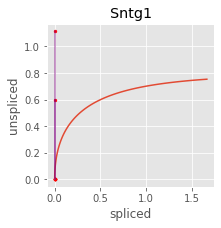

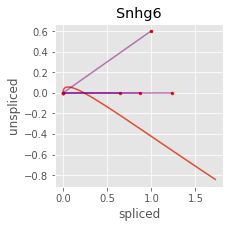

In [5]:
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}
trainer.previous_trajectory, _ = model(trainer.timepoint_choices, trainer.initial_value(None), rtol=rtol)

# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 2):
    print_scatter(cells, i)

In [6]:
tol = 1e-1
import time
start = time.time()

output = trainer.train(20, rtol=tol, atol=tol/10,
                       report_interval=1)
end = time.time()
print(end - start)

estep done
num t: torch.Size([7])
ymean, yvar, traj torch.Size([4000, 10, 1]) torch.Size([4000, 10, 1]) torch.Size([4000, 100, 1])
tensor(0., grad_fn=<MinBackward1>) tensor(16580.5039, grad_fn=<MaxBackward1>)
Epoch 001/020 - Loss: 165391.51 (165391.51  0.00  ) λ: 1.00
estep done
num t: torch.Size([6])
ymean, yvar, traj torch.Size([4000, 10, 1]) torch.Size([4000, 10, 1]) torch.Size([4000, 100, 1])
tensor(2.2571e-09, grad_fn=<MinBackward1>) tensor(16364.9316, grad_fn=<MaxBackward1>)
Epoch 002/020 - Loss: 127477.59 (127477.59  1071.14  ) λ: 1.00
estep done
num t: torch.Size([8])
ymean, yvar, traj torch.Size([4000, 10, 1]) torch.Size([4000, 10, 1]) torch.Size([4000, 100, 1])
tensor(1.3343e-11, grad_fn=<MinBackward1>) tensor(15916.7930, grad_fn=<MaxBackward1>)
Epoch 003/020 - Loss: 95011.51 (95011.51  2142.27  ) λ: 1.00
estep done
num t: torch.Size([7])
ymean, yvar, traj torch.Size([4000, 10, 1]) torch.Size([4000, 10, 1]) torch.Size([4000, 100, 1])
tensor(3.2874e-09, grad_fn=<MinBackward1>)

### Outputs after training

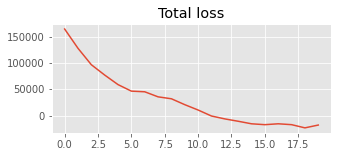

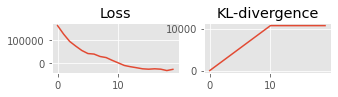

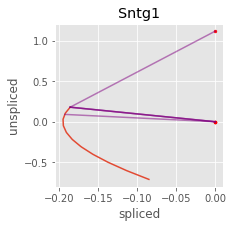

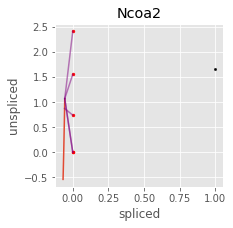

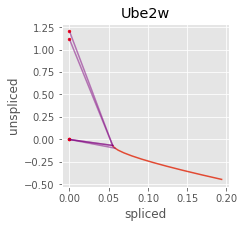

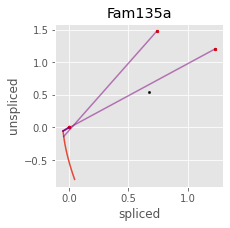

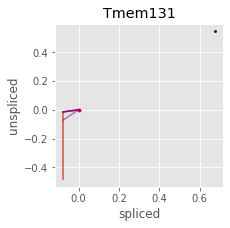

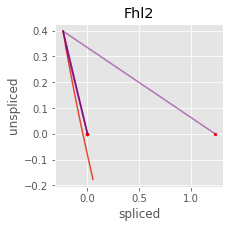

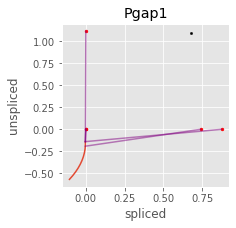

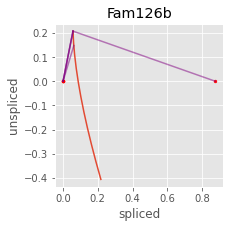

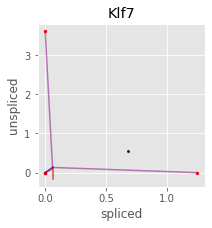

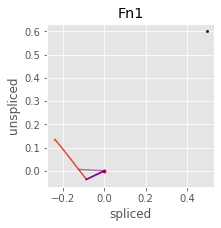

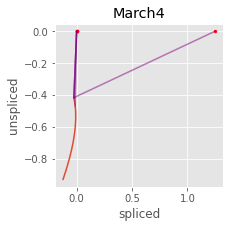

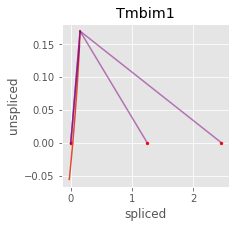

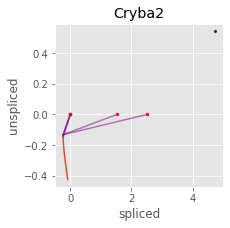

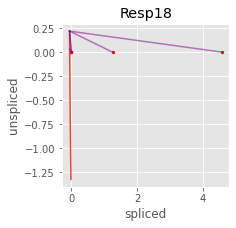

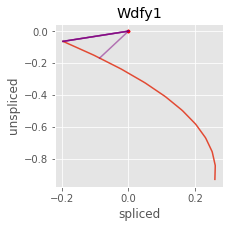

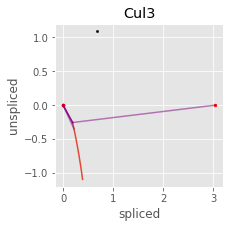

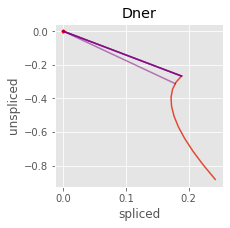

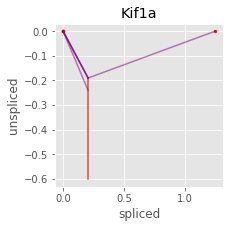

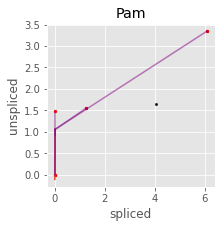

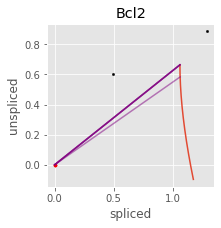

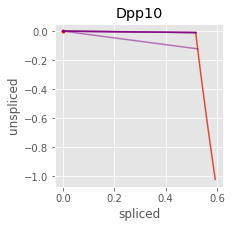

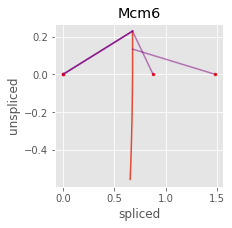

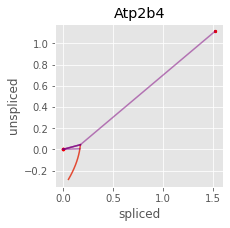

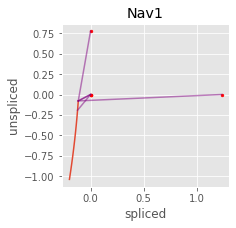

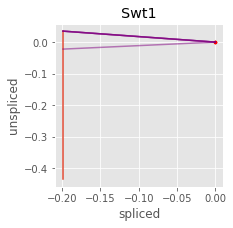

In [7]:
plotter.plot_losses(trainer, last_x=100)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=5)

In [ ]:
u = trainer.previous_trajectory[:2000].detach()  # (num_genes, 100, 1)
s = trainer.previous_trajectory[2000:].detach()  # (num_genes, 100, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[:, :1000] - u.transpose(1, 2)
s_residual = s_y[:, :1000] - s.transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
# residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = 0
residual = residual[gene_index]
print(residual.shape)
residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort()
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

for cell_index in residual_sort_indices[:100]:
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=8, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.8, c='purple')
# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)


In [ ]:
print(trainer.timepoint_choices[trainer.time_assignments_indices])
print(trainer.time_assignments_indices.shape)


In [ ]:
plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3),
                     t_scatter=t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
# plotter.plot_kinetics()
# plotter.plot_convergence(trainer)

In [ ]:
print(model.decay_rate)
print(model.transcription_rate)

In [ ]:
save(model, 'rnavelocity')

In [ ]:
do_load = False
if do_load:
    model = load('rnavelocity', RNAVelocityLFM, 2000, 1,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = EMTrainer(model, optimizer, dataset)
print(do_load)